# Visão Computacional com Aprendizado Profundo

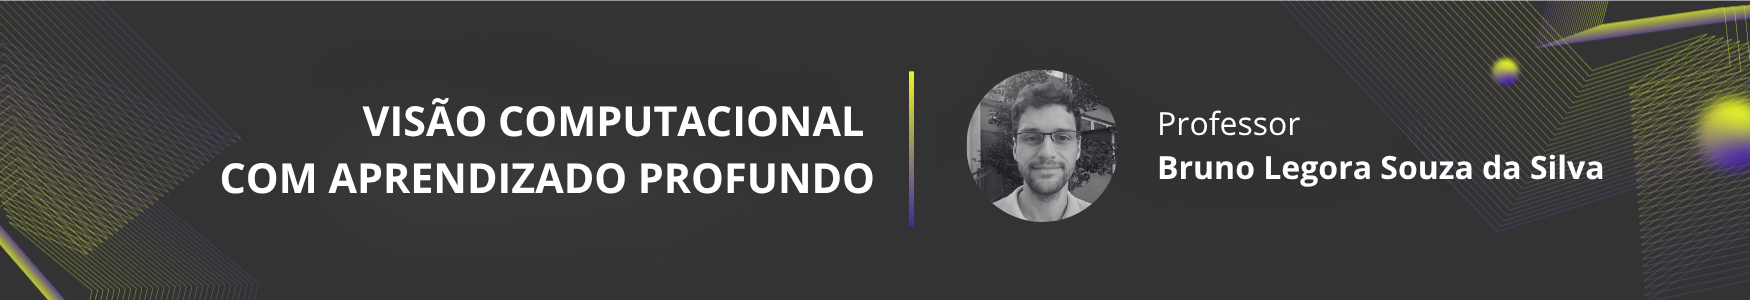

# Exercício Avaliativo nº 4

Esse exercício possui valor de 10 pontos na disciplina. Vocês irão encontrar 3 questões, façam elas nos campos de código indicados, sem remover nenhum campo de texto ou adicionar novos campos de código

In [32]:
import torch
import cv2
import numpy as np
import scipy
import torchvision
import os
from google.colab.patches import cv2_imshow
from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [33]:
print(device)

cuda


# Parte 1:

### Questão nº 01 (3 pts)

Sugira e implemente formas de melhorar o código do Laboratório 7 para melhorar a etapa de treinamento da U-net, tanto em termos de tempo de processamento quanto métrica de erro.

O resultado do código da seção abaixo deve ter perdas bem menores que as encontradas no laboratório.

Obs: Sem ser aumentar o número de iterações, trocar a arquitetura da rede ou ainda aumentar o número de épocas.






## Os três blocos de código a seguir são copia do laboratorio 7, necessários para rodar a Unet.

In [34]:
import os
working_dir = "."

pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

100%|██████████| 792M/792M [02:54<00:00, 4.53MB/s]
100%|██████████| 19.2M/19.2M [00:02<00:00, 8.27MB/s]
100%|██████████| 792M/792M [01:14<00:00, 10.6MB/s]
100%|██████████| 19.2M/19.2M [00:02<00:00, 9.34MB/s]


(500, 394)


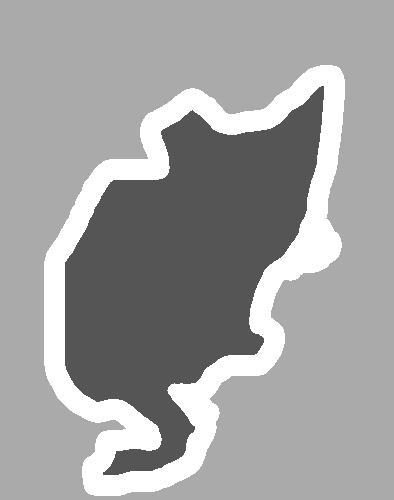

In [35]:
### Recapitulando o código anterior
# Carregando o dataset:

(train_pets_input, train_pets_target) = pets_train_orig[0]
target = np.asarray(train_pets_target)
target = target*255.0/np.max(target)

print(target.shape)
cv2_imshow(target)

def arredondaMultiplo16(num):
  return (num // 16) * 16;

def pilToResizedTensor(x):
  new_sz1 = arredondaMultiplo16(x.size[0])
  new_sz2 = arredondaMultiplo16(x.size[1])
  new_sz = (new_sz1,new_sz2)
  return torchvision.transforms.functional.pil_to_tensor(x.resize(new_sz)).float()

def transformTargets(x):
  target = pilToResizedTensor(x)
  # A saída da rede neural possui 3 classes (3 matrizes indicadoras de cada class)
  # enquanto nosso target possui 1 canal só com valores de 0 a 2.
  # Convertendo abaixo:
  target = torch.cat([ (target == i) for i in range(1,4) ], dim=0).float()
  target = target
  return target

percentage = 10

pets_train_Tensor = []
target_train_Tensor = []
pets_test_Tensor = []
target_test_Tensor = []

for i in range(len(pets_train_orig)//(100//percentage)):
  pets_train_Tensor.append(pilToResizedTensor(pets_train_orig[i][0]))
  target_train_Tensor.append(transformTargets(pets_train_orig[i][1]))


for i in range(len(pets_test_orig)//(100//percentage)):
  pets_test_Tensor.append(pilToResizedTensor(pets_test_orig[i][0]))
  target_test_Tensor.append(transformTargets(pets_test_orig[i][1]))

In [36]:
## Definição da Unet (ainda do lab 7)

class BlocoEncoder(torch.nn.Module):

    def __init__(self, num_canais_entrada, num_canais_saida, padding='valid'):
        super().__init__()
        self.layer1 = torch.nn.Conv2d(num_canais_entrada, num_canais_saida, kernel_size=3, padding=padding)
        self.layer2 = torch.nn.ReLU(inplace=True)
        self.layer3 = torch.nn.Conv2d(num_canais_saida, num_canais_saida, kernel_size=3, padding=padding)
        self.layer4 = torch.nn.ReLU(inplace=True)
        self.layer5 = torch.nn.MaxPool2d(2)

    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.layer5(x)
      return x


class BlocoDecoder(torch.nn.Module):

    def __init__(self, num_canais_entrada, num_canais_saida, padding='valid'):
        super().__init__()
        # upconv diminui o numero de canais pela metade!
        self.up = torch.nn.ConvTranspose2d(num_canais_entrada, num_canais_entrada // 2, kernel_size=2, stride=2)
        self.layer1 = torch.nn.Conv2d(num_canais_entrada, num_canais_saida, kernel_size=3, padding=padding)
        self.layer2 = torch.nn.ReLU(inplace=True)
        self.layer3 = torch.nn.Conv2d(num_canais_saida, num_canais_saida, kernel_size=3, padding=padding)
        self.layer4 = torch.nn.ReLU(inplace=True)

    def forward(self, x, skip_connection):
      x = self.up(x)
      skip_connection = torchvision.transforms.Resize((x.size()[2],x.size()[3]))(skip_connection)
      x = torch.cat([skip_connection, x], dim=1)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      return x

class UNet(torch.nn.Module):
    def __init__(self, n_channels, n_classes, padding='valid'):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.encoder1 = BlocoEncoder(n_channels,64,padding=padding)
        self.encoder2 = BlocoEncoder(64,128,padding=padding)
        self.encoder3 = BlocoEncoder(128,256,padding=padding)
        self.encoder4 = BlocoEncoder(256,512,padding=padding)
        self.base1 = torch.nn.Conv2d(512, 1024, kernel_size=3, padding=padding)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.base2 = torch.nn.Conv2d(1024, 1024, kernel_size=3, padding=padding)
        self.relu2 =  torch.nn.ReLU(inplace=True)
        self.decoder1 = BlocoDecoder(1024,512,padding=padding)
        self.decoder2 = BlocoDecoder(512,256,padding=padding)
        self.decoder3 = BlocoDecoder(256,128,padding=padding)
        self.decoder4 = BlocoDecoder(128,64,padding=padding)
        self.conv1 = torch.nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x = self.base1(x4)
        x = self.relu1(x)
        x = self.base2(x)
        x = self.relu2(x)
        x = self.decoder1(x,x4) # skip connection aqui!
        x = self.decoder2(x,x3) # skip connection aqui!
        x = self.decoder3(x,x2) # skip connection aqui!
        x = self.decoder4(x,x1) # skip connection aqui!
        x = self.conv1(x)
        return x

# Podemos criar uma U-Net com 3 canais de entrada e 2 classes da seguinte forma:
unet = UNet(3,2)

## Agora sim começa a questão

Decidir utilizar um dataloader para carregar varias imagens de uma vez, ao invés de processar uma por uma, economizando assim, tempo.

Porém, isso me levou à um problema, porque aparentemente as imagens tem tamanhos diferentes, então foi necessários fazer um resize nelas.

Além disso, eu tive um erro de conversão ao usar o CroosEntropyLoss, sendo necessário uma conversão.

In [37]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

# Redimensionar as imagens e máscaras para 256x256
resize_img = T.Resize((256, 256))  # para imagens RGB
resize_mask = T.Resize((256, 256), interpolation=InterpolationMode.NEAREST)  # para máscaras (classe por pixel)

pets_train_Tensor_resized = [resize_img(img) for img in pets_train_Tensor]
target_train_Tensor_resized = [resize_mask(mask) for mask in target_train_Tensor]

# Empilha as listas em tensores 4D
pets_train_tensor_stack = torch.stack(pets_train_Tensor_resized)
target_train_tensor_stack = torch.stack(target_train_Tensor_resized)

# Converte máscara one-hot (3 canais) para índice de classe (1 canal)
target_train_tensor_stack = target_train_tensor_stack.argmax(dim=1).long()  # shape: (N, 256, 256)

# Dataset e DataLoader
train_dataset = TensorDataset(pets_train_tensor_stack, target_train_tensor_stack)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Configuração da rede, otimizador e loss
unet = UNet(3, 3, 'same')  # 3 canais entrada, 3 canais saída (3 classes)
unet.to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0.0
    unet.train()

    for inputs, outputs in train_loader:
        inputs = inputs.to(device)
        outputs = outputs.to(device)

        optimizer.zero_grad()
        pred_targets = unet(inputs)

        loss = loss_fn(pred_targets, outputs)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch: {epoch:03d}, Train loss: {avg_loss:.6f}')


Epoch: 000, Train loss: 1.136879
Epoch: 001, Train loss: 0.958165
Epoch: 002, Train loss: 0.903568
Epoch: 003, Train loss: 1.078384
Epoch: 004, Train loss: 0.900652
Epoch: 005, Train loss: 0.851341
Epoch: 006, Train loss: 0.874159
Epoch: 007, Train loss: 0.865312
Epoch: 008, Train loss: 0.799928
Epoch: 009, Train loss: 0.799079
Epoch: 010, Train loss: 0.731747
Epoch: 011, Train loss: 0.723276
Epoch: 012, Train loss: 0.748287
Epoch: 013, Train loss: 0.697571
Epoch: 014, Train loss: 0.701558
Epoch: 015, Train loss: 0.699947
Epoch: 016, Train loss: 0.673528
Epoch: 017, Train loss: 0.663547
Epoch: 018, Train loss: 0.616081
Epoch: 019, Train loss: 0.616336


In [38]:
target_train_tensor_stack.shape

torch.Size([368, 256, 256])

# Parte 2:

Use a base de dados Berkeley Segmentation Dataset nas próximas questões. Use as variáveis "bsds_train_data", "bsds_train_targets", "bsds_test_data" e "bsds_test_targets" como conjuntos de características e targets de treino e teste, respectivamente.

Execute as células abaixo para carregar e processar a base de dados:

In [39]:
!git clone https://github.com/BIDS/BSDS500.git

fatal: destination path 'BSDS500' already exists and is not an empty directory.


In [40]:
def load_image(path):
    img = cv2.imread(path)
    if img.shape == (481, 321, 3):
        img = np.transpose(img, (1, 0, 2))
    img = img[:320, :480, :]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_labels(path):
    gt = scipy.io.loadmat(path)['groundTruth'][0][0][0][0][0]
    if gt.shape == (481, 321):
        gt = np.transpose(gt, (1, 0))
    gt = gt[:320, :480]
    gt = gt.astype(np.uint8)
    return gt

def cv2_to_Tensor(image):
  cvImg = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  return torchvision.transforms.ToTensor()(cvImg)

def arredonda_multiplo_16(num):
  return (num // 16) * 16;

def cv2_to_resized_tensor(x):
  new_sz1 = arredonda_multiplo_16(x.shape[0])
  new_sz2 = arredonda_multiplo_16(x.shape[1])
  new_sz = (new_sz2,new_sz1) # invertido pois opencv
  x = cv2.resize(x,new_sz)
  if len(x.shape) == 3:
    x = cv2_to_Tensor(x)
  else:
    x = torchvision.transforms.ToTensor()(x)
  return x

def torch_2_cv(x):
  x = x.numpy()*255
  if (len(x.shape) == 3):
    x = np.transpose(x,(1,2,0))
  return x


folder = "BSDS500/BSDS500/data/"
train_images_folder = folder + "images/train/"
test_images_folder = folder + "images/test/"
train_targets_folder = folder + "groundTruth/train/"
test_targets_folder = folder + "groundTruth/test/"

train_images = []
train_targets = []
test_images = []
test_targets = []

train_files = os.listdir(train_images_folder)
train_files = [i for i in train_files if '.jpg' in i]
train_files.sort()
test_files = os.listdir(test_images_folder)
test_files = [i for i in test_files if '.jpg' in i]
test_files.sort()

for filename in train_files:
  image = load_image(os.path.join(train_images_folder,filename))
  target = load_labels(os.path.join(train_targets_folder,filename[:-4]+".mat"))
  train_images.append(cv2_to_resized_tensor(image))
  train_targets.append(cv2_to_resized_tensor(target))

for filename in test_files:
  image = load_image(os.path.join(test_images_folder,filename))
  target = load_labels(os.path.join(test_targets_folder,filename[:-4]+".mat"))
  test_images.append(cv2_to_resized_tensor(image))
  test_targets.append(cv2_to_resized_tensor(target))


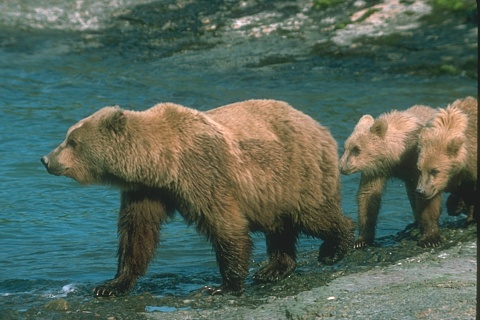

--


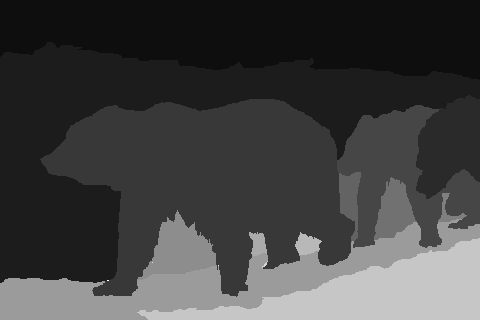

--


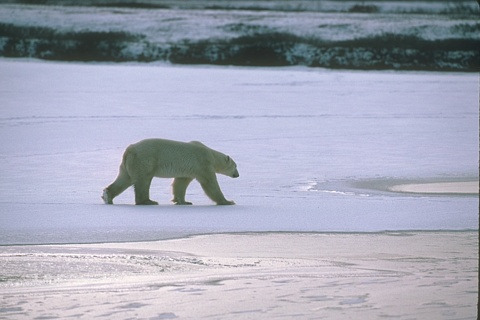

--


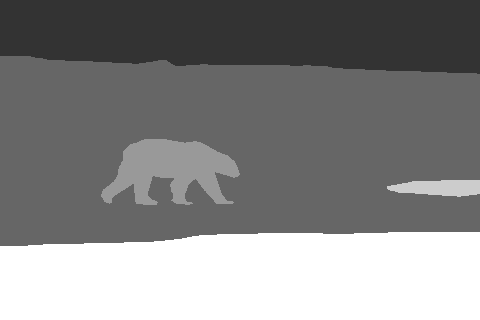

In [41]:
cv2_imshow(torch_2_cv(train_images[0]))
print("--")
tg = torch_2_cv(train_targets[0])
cv2_imshow(tg*255/np.max(tg))
print("--")
cv2_imshow(torch_2_cv(test_images[0]))
print("--")
tg = torch_2_cv(test_targets[0])
cv2_imshow(tg*255/np.max(tg))

In [42]:
train_images = [x.reshape((1,x.size()[0],x.size()[1],x.size()[2])) for x in train_images]
test_images = [x.reshape((1,x.size()[0],x.size()[1],x.size()[2])) for x in test_images]
train_targets = [x.reshape((1,x.size()[0],x.size()[1],x.size()[2])) for x in train_targets]
test_targets = [x.reshape((1,x.size()[0],x.size()[1],x.size()[2])) for x in test_targets]

train_images = torch.cat(train_images)
test_images = torch.cat(test_images)
train_targets = torch.cat(train_targets)
test_targets = torch.cat(test_targets)

print(train_images.size())
print(test_images.size())
print(train_targets.size())
print(test_targets.size())


torch.Size([200, 3, 320, 480])
torch.Size([200, 3, 320, 480])
torch.Size([200, 1, 320, 480])
torch.Size([200, 1, 320, 480])


### Questão nº 02 (2 pts)

Compare resultado da U-net com e sem as conexões residuais na base de dados Berkeley.


### Primeira parte, roda com as conexões residuais

In [43]:
# Implemente aqui!
bsds_train_data = train_images
bsds_train_targets = train_targets
bsds_test_data = test_images
bsds_test_targets = test_targets

import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

# Redimensionar imagens e máscaras para 256x256
resize_img = T.Resize((256, 256))
resize_mask = T.Resize((256, 256), interpolation=InterpolationMode.NEAREST)

# Aplica redimensionamento
bsds_train_imgs_resized = [resize_img(img) for img in bsds_train_data]
bsds_train_masks_resized = [resize_mask(mask) for mask in bsds_train_targets]

# Empilha como tensores 4D
train_imgs = torch.stack(bsds_train_imgs_resized)
train_masks = torch.stack(bsds_train_masks_resized)

# Converte para índice de classe (caso esteja com shape (N, 1, H, W))
if train_masks.ndim == 4:
    train_masks = train_masks.squeeze(1).long()  # shape: (N, H, W)

# Dataset e DataLoader
train_dataset = TensorDataset(train_imgs, train_masks)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Configuração da rede, otimizador e loss
unet = UNet(3, 2, 'same')  # 2 classes (fundo/borda)
unet.to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0.0
    unet.train()

    for inputs, outputs in train_loader:
        inputs = inputs.to(device)
        outputs = outputs.to(device)

        optimizer.zero_grad()
        pred_targets = unet(inputs)

        loss = loss_fn(pred_targets, outputs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch: {epoch:03d}, Train loss: {avg_loss:.6f}')



Epoch: 000, Train loss: 0.087483
Epoch: 001, Train loss: 0.000000
Epoch: 002, Train loss: 0.000000
Epoch: 003, Train loss: 0.000000
Epoch: 004, Train loss: 0.000000
Epoch: 005, Train loss: 0.000000
Epoch: 006, Train loss: 0.000000
Epoch: 007, Train loss: 0.000000
Epoch: 008, Train loss: 0.000000
Epoch: 009, Train loss: 0.000000
Epoch: 010, Train loss: 0.000000
Epoch: 011, Train loss: 0.000000
Epoch: 012, Train loss: 0.000000
Epoch: 013, Train loss: 0.000000
Epoch: 014, Train loss: 0.000000
Epoch: 015, Train loss: 0.000000
Epoch: 016, Train loss: 0.000000
Epoch: 017, Train loss: 0.000000
Epoch: 018, Train loss: 0.000000
Epoch: 019, Train loss: 0.000000


### Agora, removendo as conexões

In [44]:
## Definição da Unet

class BlocoEncoder(torch.nn.Module):

    def __init__(self, num_canais_entrada, num_canais_saida, padding='valid'):
        super().__init__()
        self.layer1 = torch.nn.Conv2d(num_canais_entrada, num_canais_saida, kernel_size=3, padding=padding)
        self.layer2 = torch.nn.ReLU(inplace=True)
        self.layer3 = torch.nn.Conv2d(num_canais_saida, num_canais_saida, kernel_size=3, padding=padding)
        self.layer4 = torch.nn.ReLU(inplace=True)
        self.layer5 = torch.nn.MaxPool2d(2)

    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.layer5(x)
      return x


# Alterando o decode sem skip connection
class BlocoDecoder(torch.nn.Module):

    def __init__(self, num_canais_entrada, num_canais_saida, padding='valid'):
        super().__init__()
        self.up = torch.nn.ConvTranspose2d(num_canais_entrada, num_canais_entrada // 2, kernel_size=2, stride=2)
        self.layer1 = torch.nn.Conv2d(num_canais_entrada // 2, num_canais_saida, kernel_size=3, padding=padding)
        self.layer2 = torch.nn.ReLU(inplace=True)
        self.layer3 = torch.nn.Conv2d(num_canais_saida, num_canais_saida, kernel_size=3, padding=padding)
        self.layer4 = torch.nn.ReLU(inplace=True)

    def forward(self, x, skip_connection=None):
        x = self.up(x)  # reduz canais pela metade
        # Não concatena nada
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

## Alterando o nome para comparar ambas posteriormente
class UNetSemSkip(torch.nn.Module):
    def __init__(self, n_channels, n_classes, padding='valid'):
        super(UNetSemSkip, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.encoder1 = BlocoEncoder(n_channels,64,padding=padding)
        self.encoder2 = BlocoEncoder(64,128,padding=padding)
        self.encoder3 = BlocoEncoder(128,256,padding=padding)
        self.encoder4 = BlocoEncoder(256,512,padding=padding)
        self.base1 = torch.nn.Conv2d(512, 1024, kernel_size=3, padding=padding)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.base2 = torch.nn.Conv2d(1024, 1024, kernel_size=3, padding=padding)
        self.relu2 =  torch.nn.ReLU(inplace=True)
        self.decoder1 = BlocoDecoder(1024,512,padding=padding)
        self.decoder2 = BlocoDecoder(512,256,padding=padding)
        self.decoder3 = BlocoDecoder(256,128,padding=padding)
        self.decoder4 = BlocoDecoder(128,64,padding=padding)
        self.conv1 = torch.nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x = self.base1(x4)
        x = self.relu1(x)
        x = self.base2(x)
        x = self.relu2(x)

        ## Decoder sem skip connections
        x = self.decoder1(x) # skip connection aqui!
        x = self.decoder2(x) # skip connection aqui!
        x = self.decoder3(x) # skip connection aqui!
        x = self.decoder4(x) # skip connection aqui!
        x = self.conv1(x)
        return x

# Podemos criar uma U-Net com 3 canais de entrada e 2 classes da seguinte forma:
unet = UNet(3,2)

## Agora, treinando sem o skip connection

In [45]:
# Implemente aqui!
bsds_train_data = train_images
bsds_train_targets = train_targets
bsds_test_data = test_images
bsds_test_targets = test_targets

import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

# Redimensionar imagens e máscaras para 256x256
resize_img = T.Resize((256, 256))
resize_mask = T.Resize((256, 256), interpolation=InterpolationMode.NEAREST)

# Aplica redimensionamento
bsds_train_imgs_resized = [resize_img(img) for img in bsds_train_data]
bsds_train_masks_resized = [resize_mask(mask) for mask in bsds_train_targets]

# Empilha como tensores 4D
train_imgs = torch.stack(bsds_train_imgs_resized)
train_masks = torch.stack(bsds_train_masks_resized)

# Converte para índice de classe (caso esteja com shape (N, 1, H, W))
if train_masks.ndim == 4:
    train_masks = train_masks.squeeze(1).long()  # shape: (N, H, W)

# Dataset e DataLoader
train_dataset = TensorDataset(train_imgs, train_masks)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Configuração da rede, otimizador e loss

# Rede sem o skip, declarando lá em cima
unet = UNetSemSkip(3, 2, 'same')  # 2 classes (fundo/borda)
unet.to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0.0
    unet.train()

    for inputs, outputs in train_loader:
        inputs = inputs.to(device)
        outputs = outputs.to(device)

        optimizer.zero_grad()
        pred_targets = unet(inputs)

        loss = loss_fn(pred_targets, outputs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch: {epoch:03d}, Train loss: {avg_loss:.6f}')



Epoch: 000, Train loss: 0.103134
Epoch: 001, Train loss: 0.000000
Epoch: 002, Train loss: 0.000000
Epoch: 003, Train loss: 0.000000
Epoch: 004, Train loss: 0.000000
Epoch: 005, Train loss: 0.000000
Epoch: 006, Train loss: 0.000000
Epoch: 007, Train loss: 0.000000
Epoch: 008, Train loss: 0.000000
Epoch: 009, Train loss: 0.000000
Epoch: 010, Train loss: 0.000000
Epoch: 011, Train loss: 0.000000
Epoch: 012, Train loss: 0.000000
Epoch: 013, Train loss: 0.000000
Epoch: 014, Train loss: 0.000000
Epoch: 015, Train loss: 0.000000
Epoch: 016, Train loss: 0.000000
Epoch: 017, Train loss: 0.000000
Epoch: 018, Train loss: 0.000000
Epoch: 019, Train loss: 0.000000


Comparando ambas as redes, como a perca é 0 já na segunda época, temos duas conclusões: Ou a base de dados é "muito fácil" ou muito pequeno.

### Questão nº 03 (1 pt)

Responda: É possível usar funções de ativação como a softmax em problemas de segmentação? Se sim, explique como. Se não, explique o motivo.


Sim! A função softmax é muito usada em segmentação porque ela transforma a saída da rede em probabilidades para cada classe em cada pixel, ajudando a saber qual classe o modelo acha mais provável.

### Questão nº 04 (2 pt)

Crie uma arquitetura de rede totalmente convolucional onde não há perda de resolução em nenhuma camada convolucional. Não use a camada de deconvolução ou pooling, apenas as camadas de convolução com padding.

Treine-a na base de dados Berkeley e faça uma breve comparação com os resultados obtidos ao usar a U-net


In [46]:
# Implemente aqui!
import torch
import torch.nn as nn

class RedeTotalmenteConvolucional(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)  # mantém resolução
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)           # mantém resolução
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(64, out_channels, kernel_size=1, padding=0) # mantém resolução

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.conv3(x)
        return x


In [47]:
# Implemente aqui!

## Segui o mesmo estilo utilizado nas questões anteriores
bsds_train_data = train_images
bsds_train_targets = train_targets
bsds_test_data = test_images
bsds_test_targets = test_targets

# Redimensionar imagens e máscaras para 256x256
resize_img = T.Resize((256, 256))
resize_mask = T.Resize((256, 256), interpolation=InterpolationMode.NEAREST)

# Aplica redimensionamento
bsds_train_imgs_resized = [resize_img(img) for img in bsds_train_data]
bsds_train_masks_resized = [resize_mask(mask) for mask in bsds_train_targets]

bsds_test_imgs_resized = [resize_img(img) for img in bsds_test_data]
bsds_test_masks_resized = [resize_mask(mask) for mask in bsds_test_targets]

# Empilha como tensores 4D
train_imgs = torch.stack(bsds_train_imgs_resized)
train_masks = torch.stack(bsds_train_masks_resized)
test_imgs = torch.stack(bsds_test_imgs_resized)
test_masks = torch.stack(bsds_test_masks_resized)

if train_masks.ndim == 4:
    train_masks = train_masks.squeeze(1).long()  # shape: (N, H, W)
if test_masks.ndim == 4:
    test_masks = test_masks.squeeze(1).long()  # shape: (N, H, W)

# Dataset e DataLoader
train_dataset = TensorDataset(train_imgs, train_masks)
test_dataset = TensorDataset(test_imgs, test_masks)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = RedeTotalmenteConvolucional(in_channels=3, out_channels=2)  # 2 classes (fundo/borda)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # saída (N, 2, H, W)

        loss = loss_fn(outputs, targets)  # targets (N, H, W)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch: {epoch:03d}, Train loss: {avg_loss:.6f}')

model.eval()
total_correct = 0
total_pixels = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        preds = outputs.argmax(dim=1)  # (N, H, W)

        total_correct += (preds == targets).sum().item()
        total_pixels += targets.numel()

acc = total_correct / total_pixels
print(f'Test accuracy: {acc:.4f}')


Epoch: 000, Train loss: 0.164882
Epoch: 001, Train loss: 0.001377
Epoch: 002, Train loss: 0.000270
Epoch: 003, Train loss: 0.000113
Epoch: 004, Train loss: 0.000059
Epoch: 005, Train loss: 0.000036
Epoch: 006, Train loss: 0.000024
Epoch: 007, Train loss: 0.000017
Epoch: 008, Train loss: 0.000013
Epoch: 009, Train loss: 0.000011
Epoch: 010, Train loss: 0.000009
Epoch: 011, Train loss: 0.000007
Epoch: 012, Train loss: 0.000006
Epoch: 013, Train loss: 0.000005
Epoch: 014, Train loss: 0.000005
Epoch: 015, Train loss: 0.000004
Epoch: 016, Train loss: 0.000004
Epoch: 017, Train loss: 0.000003
Epoch: 018, Train loss: 0.000003
Epoch: 019, Train loss: 0.000003
Test accuracy: 1.0000


Comparando com a Unet (Com ou sem skip), temos que a unet converge mais rápido, já  nas primeiras épocas, enquanto o modelo totalmente convolucional tem uma convergência mais lenta.

Olhando "a olho nu", percebi que  o modelo totalmente convolucional foi processado mais rápido se comparado com os modelos da unet.

### Questão nº 05 (2 pts)

Vimos que, na U-net, pode ou não haver uso de padding. Para que a saída tenha tamanho igual à entrada, devemos usá-lo.

Faça um breve teste: Treine a U-net com padding e compare a saída dela com uma u-net treinada sem padding. A saída dessa segunda deve ser redimensionada para que ela volte a resolução original.

Ex: Na imagem da U-net, a entrada era 572x572 e a saída era 388x388. Use algum método resize para voltar a imagem de 388x388 para a resolução original.

Faça uma análise visual e compare os erros quadráticos médios das duas abordagens.

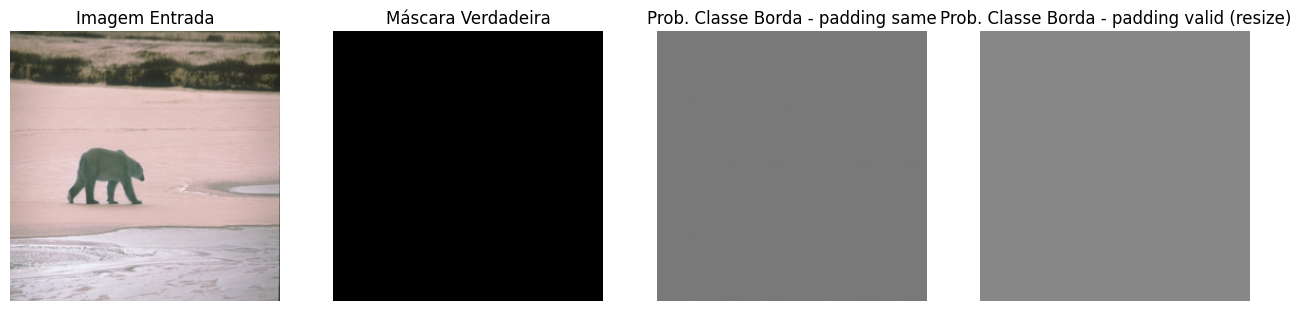

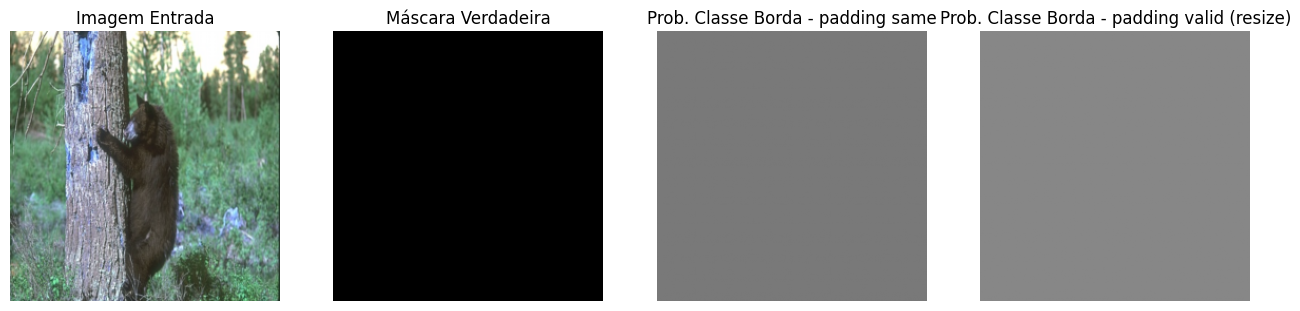

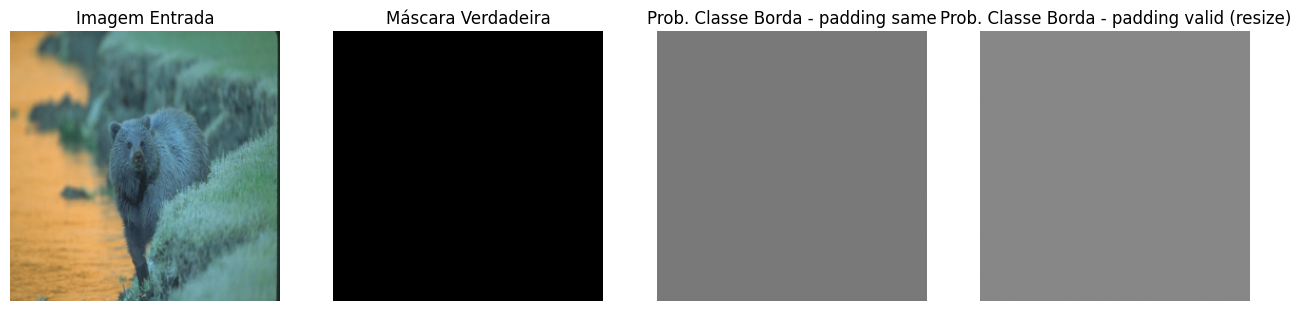

MSE médio com padding same: 0.225317
MSE médio com padding valido (resize): 0.280362


In [48]:
# Implemente aqui!

unet_same = UNet(3, 2, padding='same').to(device)
unet_valid = UNet(3, 2, padding='valid').to(device)

def mse_loss(pred, target):
    return ((pred.float() - target.float()) ** 2).mean().item()


resize_img = T.Resize((256, 256))
resize_mask = T.Resize((256, 256), interpolation=InterpolationMode.NEAREST)

bsds_test_imgs_resized = [resize_img(img) for img in bsds_test_data]
bsds_test_masks_resized = [resize_mask(mask) for mask in bsds_test_targets]

test_imgs = torch.stack(bsds_test_imgs_resized)
test_masks = torch.stack(bsds_test_masks_resized)

if test_masks.ndim == 4:
    test_masks = test_masks.squeeze(1).long()  # (N, H, W)

test_dataset = TensorDataset(test_imgs, test_masks)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

import torch.nn.functional as F
import matplotlib.pyplot as plt

unet_same.eval()
unet_valid.eval()

mse_same_total = 0
mse_valid_total = 0

with torch.no_grad():
    for i, (imgs, masks) in enumerate(test_loader):
        imgs = imgs.to(device)
        masks = masks.to(device).float()

        # Inferência na U-Net com padding same
        pred_same = unet_same(imgs)
        pred_same_soft = F.softmax(pred_same, dim=1)

        # Inferência na U-Net com padding valid
        pred_valid = unet_valid(imgs)
        pred_valid_soft = F.softmax(pred_valid, dim=1)  # softmax antes do resize
        pred_valid_soft_resized = F.interpolate(pred_valid_soft, size=(256, 256), mode='bilinear', align_corners=False)

        # Cálculo do MSE usando a probabilidade da classe 1 (borda)
        mse_same = ((pred_same_soft[:,1,:,:] - masks) ** 2).mean().item()
        mse_valid = ((pred_valid_soft_resized[:,1,:,:] - masks) ** 2).mean().item()

        mse_same_total += mse_same
        mse_valid_total += mse_valid

        # Visualização para as primeiras 3 imagens
        if i < 3:
            plt.figure(figsize=(16,5))

            plt.subplot(1,4,1)
            plt.imshow(imgs[0].cpu().permute(1, 2, 0))
            plt.title("Imagem Entrada")
            plt.axis('off')

            plt.subplot(1,4,2)
            plt.imshow(masks[0].cpu(), cmap='gray', vmin=0, vmax=1)
            plt.title("Máscara Verdadeira")
            plt.axis('off')

            plt.subplot(1,4,3)
            plt.imshow(pred_same_soft[0,1].cpu(), cmap='gray', vmin=0, vmax=1)
            plt.title("Prob. Classe Borda - padding same")
            plt.axis('off')

            plt.subplot(1,4,4)
            plt.imshow(pred_valid_soft_resized[0,1].cpu(), cmap='gray', vmin=0, vmax=1)
            plt.title("Prob. Classe Borda - padding valid (resize)")
            plt.axis('off')

            plt.show()


print(f"MSE médio com padding same: {mse_same_total / len(test_loader):.6f}")
print(f"MSE médio com padding valido (resize): {mse_valid_total / len(test_loader):.6f}")


